We solve the portfolio optimization problem with a CVaR risk constraint.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import t, norm
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.distributions.copula.api import StudentTCopula
import random
from scipy import optimize
import cvxpy as cp
from cvxopt import matrix, solvers
from cvxopt.modeling import variable, op

In [2]:
solvers.options['reltol'] = 1e-6 # default 1e-6
solvers.options['abstol'] = 1e-7 # default 1e-7
solvers.options['feastol'] = 1e-4 # default 1e-7
solvers.options['maxiters'] = 150 # default 100


# Load the data

In [3]:
folderpath = "Data/Simulations/OPTIMIZATION 2005-2019"

# Pre-computed simulated scenarios are loaded here
scenarios = pd.read_csv(f"{folderpath}/Simulation_exp_returns.csv", index_col=0)#.iloc[:,:-4]
# scenarios = pd.read_csv(f"{folderpath}/Simulation_exp_returns_monthly.csv", index_col=0) # monthly scenarios
scenarios[scenarios.shape[1]] = np.repeat(1.0, scenarios.shape[0])
scenarios

,0,1,2,3,4,5,6,7,8,9,...,720,721,722,723,724,725,726,727,728,729
new_index,,,,,,,,,,,,,,,,,,,,,
0,0.696532,1.025622,0.982275,0.719775,1.108006,1.270277,1.337133,1.013219,1.063612,1.018497,...,1.253989,1.074693,0.979542,0.723668,1.040370,0.877917,0.894527,1.004333,1.004980,1.0
1,0.922545,1.221445,1.507715,1.901371,0.923985,1.452404,1.580681,1.139178,0.879998,1.466240,...,1.552791,1.259335,1.845842,0.412447,1.239004,1.322753,1.461216,1.130695,1.148899,1.0
2,1.022666,2.194162,1.275159,1.651282,1.308972,1.103372,1.061096,1.240752,1.539880,0.845409,...,0.267660,1.253720,0.907283,0.697726,1.088086,1.184174,1.225168,1.055808,1.238976,1.0
3,1.018432,0.848273,1.145100,2.751649,1.024470,0.998300,0.896368,1.202730,0.726916,1.526658,...,0.324855,0.684151,1.156612,0.891037,0.929537,0.912962,1.034332,0.861927,0.933205,1.0
4,1.197944,1.674973,2.278640,1.560284,1.631752,1.190085,1.083460,1.573987,1.289515,1.638251,...,1.038853,0.803109,1.090147,2.329419,1.146479,1.302765,1.293328,1.163376,1.177041,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9937,0.700852,1.132200,0.714173,1.557171,0.964984,1.036014,0.587062,1.069135,1.180818,1.231423,...,1.014067,0.824228,1.217539,1.468680,1.179677,1.214941,1.432961,1.162897,1.203408,1.0
9938,0.949360,1.107588,0.946506,1.184037,0.917880,1.378435,0.661206,1.170548,0.595753,0.930574,...,1.292999,1.335952,0.993151,1.285580,1.177230,1.018061,1.118162,1.233519,1.102035,1.0
9939,1.060961,1.159732,1.257244,1.315800,1.238946,1.718190,0.853549,1.142884,0.620840,1.628784,...,0.792751,1.111588,1.358180,2.401518,1.110303,1.102655,1.220795,1.005774,1.216358,1.0


Also pre-compiled is a list of statistics for all companies. In light of the optimization, the most relevant ones include the simulated return rates and calculated emission intensities

In [4]:
summary = pd.read_csv(f"{folderpath}/COMPANY_SUMMARY_2.csv", index_col=0)#.iloc[:-4,:]
summary.loc["CASH",:] = np.repeat(np.nan, summary.shape[1])
summary.loc["CASH", ["Monthly RR (mean)", "Yearly RR (mean)", 'Emission intensity (tCO2e/MEUR)']] = [1.0, 1.0, 0.0]
summary["index"] = range(len(summary))
summary.loc[["^GSPC", "^FCHI", "^GDAXI", "^FTSE", "^SSMI"], "Emission intensity (tCO2e/MEUR)"] = [0,0,0,0,0]
summary

,Country,Company Name,CDP Score,Industry,CE (tCO2e),Estimated EVIC (MEUR),Emission intensity (tCO2e/MEUR),KS p-value,DoF,Location,...,Difference of mean and median,Simulated min (monthly),Simulated max (monthly),Data min (monthly),Data max (monthly),Simulated 0.90-CVaR (monthly),Simulated 0.90-CVaR (yearly),Empirical 0.90-CVaR (monthly),Empirical 0.95-CVaR (monthly),index
AGR.VI,Austria,AGRANA Beteiligungs-AG,3.0,"Food, beverage & agriculture",381000.0,2035.221761,187.203187,0.995929,6.128094,0.002111,...,0.025303,-0.615822,0.496486,-0.185977,0.253823,0.104540,0.301417,0.105519,0.129969,0
ANDR.VI,Austria,ANDRITZ AG,4.5,Manufacturing,222452.0,3354.578799,66.312945,0.979662,4.706482,0.017056,...,0.057403,-0.949877,1.174923,-0.498934,0.254428,0.126969,0.270511,0.149753,0.204821,1
CAI.VI,Austria,CA Immobilien Anlagen AG,7.0,Infrastructure,50945.0,4327.273630,11.773002,0.938119,1.924503,0.008265,...,0.111653,-3.927275,3.632792,-0.356965,0.511930,0.149836,0.439483,0.165850,0.220536,2
EBS.VI,Austria,Erste Group Bank AG,5.5,Services,71950.0,63710.792646,1.129322,0.913163,2.632979,0.014417,...,0.105357,-3.201627,2.634040,-0.507445,0.508215,0.168732,0.413232,0.213051,0.267602,3
EVN.VI,Austria,EVN AG,5.0,Infrastructure,3050754.0,6717.123518,454.175659,0.993103,3.830549,0.005547,...,0.026317,-1.030443,0.950417,-0.260698,0.211472,0.101617,0.270039,0.109880,0.135954,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
^FCHI,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.978777,12.957709,0.004077,...,0.012897,-0.233927,0.231474,-0.145225,0.118287,0.074273,0.202063,0.087423,0.107411,725
^GDAXI,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.921631,5.094028,0.010095,...,0.016297,-0.418190,0.408225,-0.213096,0.154968,0.075279,0.160775,0.091951,0.122470,726
^FTSE,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.889567,5.067769,0.004515,...,0.010110,-0.353391,0.318220,-0.145184,0.109143,0.064843,0.172366,0.078659,0.099650,727
^SSMI,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.932737,7.824222,0.007076,...,0.007566,-0.243346,0.226084,-0.114597,0.097818,0.052248,0.116695,0.063010,0.078402,728


### Plot the distribution of returns

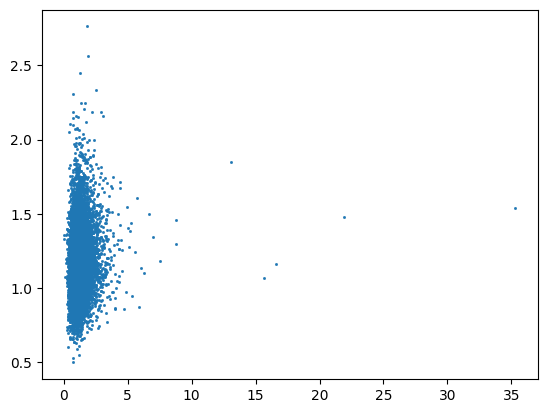

In [8]:
a = 675,682 # test different values
returns1 = scenarios.loc[:,str(a[0])]
returns2 = scenarios.loc[:,str(a[1])]
plt.scatter(returns1, returns2, linewidths=0.1, s=4, marker='o')
# plt.xlim((-1,3))
plt.show()

### Create indicator variables for industry and country

In [9]:
industries = summary["Industry"].dropna().unique()
countries = summary["Country"].dropna().unique()
industry_indicators = pd.DataFrame(index=summary.index)
country_indicators = pd.DataFrame(index=summary.index)

for industry in industries:
    indicator_name = f"Industry_{industry}"
    industry_indicators[indicator_name] = (summary["Industry"] == industry)*1

for country in countries:
    indicator_name = f"Country_{country}"
    country_indicators[indicator_name] = (summary["Country"] == country)*1

pd.concat((country_indicators.sum(),industry_indicators.sum()))
# countries
# industries

Country_Austria                                                  19
Country_Belgium                                                  28
Country_Denmark                                                  22
Country_Finland                                                  25
Country_France                                                  109
Country_Germany                                                  12
Country_Italy                                                    37
Country_Netherlands                                              28
Country_Norway                                                   20
Country_Sweden                                                   63
Country_Switzerland                                              74
Country_United Kingdom of Great Britain and Northern Ireland     99
Country_United States of America                                188
Industry_Food, beverage & agriculture                            37
Industry_Manufacturing                          

# Optimization with cvxopt.modeling

In [12]:
omega_values = [0.01,0.03,0.05,0.1,0.15,0.2,0.3] # CVaR thresholds to produce the efficient frontier
V = 1 # Portfolio value
beta = 0.025 # Maximum investment in one asset
alpha = 0.99 # CVaR confidence level
max_emis = 15 # Maximum emissions intensity (tCO2e/MEUR)
max_industry = 0.2 # Maximum constitution of a single industry
max_country = 0.2 # Maximum constitution of a single country


J = 6000 # scenarios used
j0 = 0 # start index

R = matrix(scenarios.to_numpy()[j0:j0+J,:])
y = matrix(summary["Yearly RR (mean)"])
# y = matrix(summary["Monthly RR (mean)"]) # for monthly optimization
n = len(y)

E = matrix(summary["Emission intensity (tCO2e/MEUR)"])
I_np = np.identity(n)
I_np[n-1,n-1] = 0 # we won't limit the amount "invested" in cash
I = matrix(I_np)

# industry and country matrices
II = matrix(np.array(industry_indicators).transpose(), tc='d')
IC = matrix(np.array(country_indicators).transpose(), tc='d')

# Initialize result array
opt_results = pd.DataFrame(columns=omega_values)


for omega in omega_values:
    print(f"\nOptimizing for omega = {omega}")
    # Create variables
    x = variable(n, "x")
    z = variable(J, "z")
    zeta = variable(1, "VaR")

    # Loss and objective function
    L = -y.T * x + V
    obj = -y.T * x

    # Constraints
    c1 = (sum(x) == V) # portfolio value
    c2 = (x >= 0)
    c3 = (z >= 0)
    c5 = (I * x <= beta) # asset diversification
    c6 = (zeta + 1/(J*(1-alpha))*sum(z) <= omega) # CVaR constraint
    c7 = (-R * x + V - zeta <= z) # CVaR constraint
    c8 = (E.T * x <= max_emis) # emission constraint
    c9 = (II * x <= max_industry) # industry diversification
    c10 = (IC * x <= max_country) # country diversification

    # Solve the optimization problem
    problem = op(obj, [c1,c2,c3,c5,c6,c7,c8,c9,c10])
    problem.solve()
    problem.status

    # Handle the results
    returns = float((y.T * x.value - V)[0])
    financed_emissions = float((E.T * x.value)[0])
    portfolio_return_scenarios = pd.DataFrame(R * x.value - V).sort_values(0)
    cvar = -portfolio_return_scenarios[:int((1-alpha)*J)].mean()
    industries_constitution = II * x.value
    countries_constitution = IC * x.value
    opt_results[omega] = pd.concat((pd.DataFrame(x.value), pd.DataFrame(np.repeat(returns,1)), pd.DataFrame(np.repeat(financed_emissions,1)), pd.DataFrame(np.repeat(cvar,1)), pd.DataFrame(countries_constitution), pd.DataFrame(industries_constitution)))
    # opt_results.to_csv(f"{folderpath}/x_optimized_{j0}+{J}_{alpha}_{beta}_{max_emis}_FRONTIER.csv", sep=";")
    opt_results.to_csv(f"{folderpath}/x_optimized.csv", sep=";")


Optimizing for omega = 0.01
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0204e+00  6.1103e+03  1e+04  2e+00  6e+03  1e+00
 1: -1.9279e+00  1.8702e+03  1e+03  5e-01  2e+03  2e+00
 2: -1.4102e+00  4.0128e+02  1e+02  1e-01  4e+02  5e-01
 3: -1.3396e+00  1.6157e+02  3e+01  4e-02  2e+02  2e-01
 4: -1.2808e+00  8.9660e+01  1e+01  2e-02  9e+01  1e-01
 5: -1.2554e+00  6.9436e+01  1e+01  2e-02  7e+01  8e-02
 6: -1.2350e+00  5.1994e+01  9e+00  1e-02  5e+01  6e-02
 7: -1.2194e+00  3.7695e+01  7e+00  1e-02  4e+01  4e-02
 8: -1.2155e+00  2.9414e+01  6e+00  8e-03  3e+01  2e-02
 9: -1.2178e+00  2.3619e+01  5e+00  6e-03  2e+01  2e-02
10: -1.2236e+00  1.6986e+01  4e+00  5e-03  2e+01  7e-03
11: -1.2235e+00  1.5016e+01  4e+00  4e-03  2e+01  5e-03
12: -1.2232e+00  1.0332e+01  3e+00  3e-03  1e+01  2e-03
13: -1.2221e+00  8.6614e+00  3e+00  3e-03  1e+01  2e-03
14: -1.2217e+00  7.8553e+00  3e+00  2e-03  9e+00  2e-03
15: -1.2219e+00  5.6416e+00  2e+00  2e-03  7e+00  9e-04
16: -1.2222e+00  4.84

# Numerical results

In [15]:
optimal_portfolios = pd.read_csv(f"{folderpath}/x_optimized.csv", sep=";", index_col=0)
x = optimal_portfolios.iloc[732,:]
y = optimal_portfolios.iloc

0.01    0.01
0.03    0.03
0.05    0.05
0.1     0.10
0.15    0.15
0.2     0.20
Name: 0, dtype: float64

# Out-of-sample testing

In [10]:
# Import the price data
actual_returns = pd.read_csv(f"{folderpath}/Actual_exp_returns.csv", index_col=0)
t_period = len(actual_returns)
actual_returns["CASH"] = np.repeat(1.0, t_period)
actual_returns = actual_returns.loc[:,summary.index]
for t in range(2,t_period):
    actual_returns.iloc[t,:] = actual_returns.iloc[t-1,:] * actual_returns.iloc[t,:]

actual_returns

,AGR.VI,ANDR.VI,CAI.VI,EBS.VI,EVN.VI,FLU.VI,IIA.VI,LNZ.VI,OMV.VI,PAL.VI,...,WTI,WTRG,WYNN,X,^GSPC,^FCHI,^GDAXI,^FTSE,^SSMI,CASH
2019-12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2020-1,1.032258,0.926042,1.061415,0.988081,1.030637,0.965563,1.048117,0.862319,0.898363,0.955556,...,0.764572,1.118551,0.917722,0.818146,1.015220,0.970599,0.979845,0.973225,1.019468,1.0
2020-2,0.944086,0.831250,0.987984,0.924613,0.877778,0.801324,0.974895,0.734299,0.755791,0.770940,...,0.481559,0.933032,0.794365,0.726301,0.932526,0.887614,0.897452,0.868266,0.946341,1.0
2020-3,0.870968,0.763857,0.819760,0.503129,0.772399,0.622516,0.680335,0.608696,0.502396,0.595668,...,0.313916,0.880260,0.441459,0.569719,0.813391,0.734864,0.749931,0.716253,0.901968,1.0
2020-4,0.904301,0.801809,0.775701,0.590733,0.824509,0.705960,0.706276,0.643275,0.597045,0.710357,...,0.518704,0.916566,0.636150,0.703181,0.929475,0.764295,0.819808,0.761722,0.932130,1.0
2020-5,0.935484,0.901768,0.836978,0.588945,0.890517,0.741722,0.704603,0.543456,0.635810,0.706056,...,0.479838,0.948002,0.608129,0.723628,0.953862,0.784899,0.874545,0.760782,0.943887,1.0
2020-6,0.984946,0.865954,0.819023,0.624255,0.869672,0.698383,0.635983,0.507719,0.636665,0.702472,...,0.412904,0.901397,0.535813,0.640113,0.956884,0.825110,0.929196,0.760220,0.963269,1.0
2020-7,0.978622,0.773085,0.734773,0.563170,0.814087,0.712185,0.587029,0.486153,0.571630,0.836874,...,0.387734,0.916813,0.493566,0.559377,0.956456,0.799651,0.929380,0.733599,0.951236,1.0
2020-8,0.996558,0.761141,0.749704,0.607271,0.817561,0.717706,0.581590,0.535446,0.583182,0.815398,...,0.381111,0.860575,0.593619,0.656029,1.019520,0.826987,0.977083,0.752342,0.965200,1.0
2020-9,0.918088,0.715538,0.725335,0.532628,0.826825,0.641226,0.565272,0.579194,0.500604,0.859080,...,0.312239,0.827245,0.494767,0.624202,0.994224,0.802953,0.963146,0.723540,0.967762,1.0


Plot the scenarios for a custom time interval.

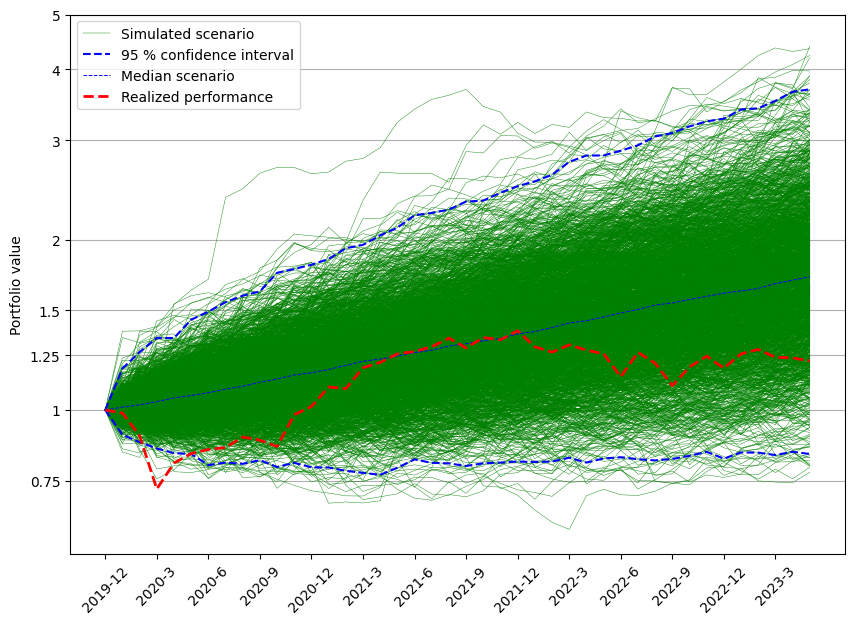

In [14]:
plotting_interval = 41

x_dates = actual_returns.index[0:plotting_interval + 1]

# 3 options to be used as the x-vector (weights):
xval = pd.read_csv(f"{folderpath}/x_plot.csv", sep=";", header=None)[6].to_numpy() # import the values from a csv file
# xval = np.matrix(x.value) # use the result from the latest optimization
# xval_temp = [random.uniform(0,1) for i in range(len(xval))]; xval = [xval_temp[i]/sum(xval_temp) for i in range(len(xval_temp))] # create a random vector

portfolio_performance = np.matmul(actual_returns.iloc[:plotting_interval + 1], xval) # the value of the portfolio, using actualized market prices

simulation_scenarios = pd.read_csv(f"{folderpath}/Simulation_exp_returns_monthly.csv", index_col=0)
simulation_scenarios["CASH"] = np.repeat(1.0, len(simulation_scenarios))
scenarios_weighted = np.matmul(simulation_scenarios.iloc[:, summary["index"]], xval) # individual simulated scenarios with the fixed weights

def plot_scenarios(scenario_count, weighted_scenarios, period, reference, conf_level):
    plt.figure(figsize=(10,7))
    periodic = weighted_scenarios.copy().reset_index()[:scenario_count*period]
    periodic["new_index"] = periodic.index % scenario_count
    all_scenario_points = pd.DataFrame(np.zeros((scenario_count, period+1)) + 1)
    conf_int = pd.DataFrame(np.zeros((period+1, 3)), columns=["lower", "upper", "median"])
    for scenario in range(scenario_count):
        scenario_returns = periodic[periodic["new_index"]==scenario]
        scenario_returns = np.concatenate((np.repeat(1,1),scenario_returns[0]))
        for t in range(1,period+1):
            scenario_point = scenario_returns[t-1]*scenario_returns[t]
            scenario_returns[t] = scenario_point
            all_scenario_points.iloc[scenario, t] = scenario_point
        scenario_handle, = plt.plot(x_dates, scenario_returns, linestyle='solid', linewidth=0.3, color="green")
    for t in range(period+1):
        time_scenarios = np.sort(all_scenario_points.iloc[:,t])
        all_scenario_points.iloc[:,t] = time_scenarios
        conf_int.iloc[t,0] = time_scenarios[int((1-conf_level)/2*len(time_scenarios))]
        conf_int.iloc[t,1] = time_scenarios[int((conf_level+1)/2*len(time_scenarios))]
        conf_int.iloc[t,2] = time_scenarios[int(len(time_scenarios)/2)]
    confint_handle, = plt.plot(x_dates, conf_int["lower"], color="blue", linestyle="dashed")
    plt.plot(x_dates, conf_int["upper"], color="blue", linestyle="dashed")
    median_handle, = plt.plot(x_dates, conf_int["median"], color="blue", linestyle="dashed", linewidth=0.7)

    reference_handle, = plt.plot(x_dates, reference, linestyle="dashed", color="red", linewidth=2)
    plt.yscale("log")
    plt.yticks([],minor=True); plt.yticks([0.75,1,1.25,1.5,2,3,4,5], [0.75,1,1.25,1.5,2,3,4,5], minor=False)
    plt.legend(handles=[scenario_handle, confint_handle, median_handle, reference_handle], labels=["Simulated scenario", "99 % confidence interval", "Median scenario", "Realized performance"])
    plt.ylabel("Portfolio value")
    plt.xticks(np.arange(0,plotting_interval+1,3))
    plt.tick_params(axis='x', labelrotation = 45)
    plt.grid(visible=True, which="major", axis="y")
    try:
        plt.ticklabel_format(axis="y", style='plain')
    except AttributeError:
        pass
    plt.savefig(f"Pictures/Performance_scenarios_vs_realized_UNIFORM.png", dpi=300, bbox_inches="tight")
    plt.show()
    return conf_int


scenario_returns = plot_scenarios(2000, scenarios_weighted, plotting_interval, portfolio_performance, 0.99)

### Compare different portfolios

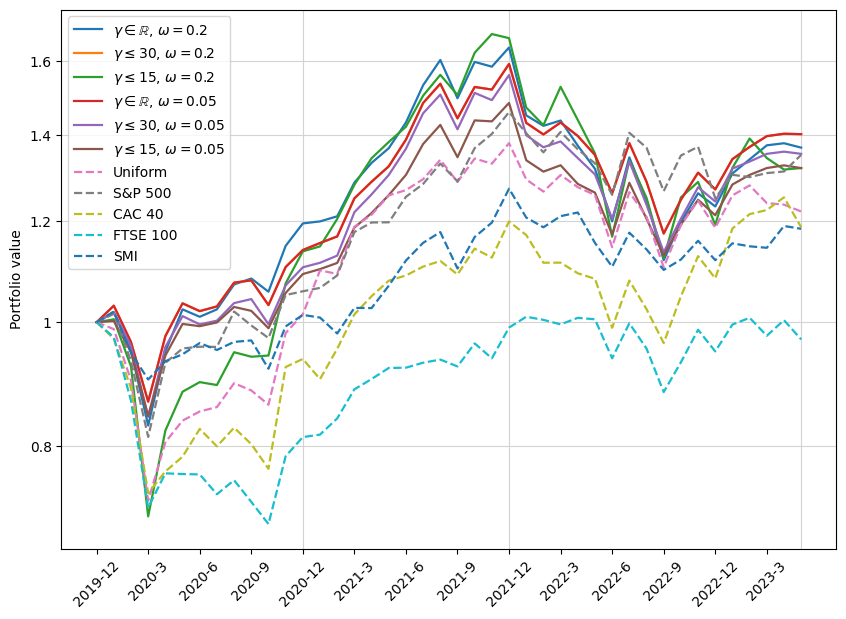

,0,6,12,18,24,30,36,41
"$\gamma\in \mathbb{R}$, $\omega=0.2$",1.000002,1.009868,1.1948,1.432974,1.640349,1.199234,1.231913,1.369601
"$\gamma\leq 30$, $\omega=0.2$",1.0,1.020213,1.138935,1.389463,1.592387,1.261312,1.270284,1.403261
"$\gamma\leq 15$, $\omega=0.2$",1.0,0.897746,1.136151,1.422086,1.668183,1.166527,1.191754,1.320088
"$\gamma\in \mathbb{R}$, $\omega=0.05$",1.0,1.020213,1.138935,1.389463,1.592387,1.261312,1.270284,1.403261
"$\gamma\leq 30$, $\omega=0.05$",1.0,0.996142,1.104029,1.366813,1.5609,1.204677,1.243037,1.354337
"$\gamma\leq 15$, $\omega=0.05$",1.000001,0.99291,1.090668,1.303969,1.484441,1.171075,1.212522,1.320056
Uniform,1.0,0.851559,1.014521,1.268713,1.380644,1.144663,1.185476,1.220703
S&P 500,1.0,0.956884,1.057322,1.25343,1.460259,1.257872,1.250225,1.351874
CAC 40,1.0,0.82511,0.936009,1.087862,1.199092,0.990077,1.082167,1.186633
FTSE 100,1.0,0.76022,0.813109,0.921401,0.990416,0.937099,0.948814,0.969474


In [14]:
filename = f"{folderpath}/x_plot.csv"
legend_entries = [r"$\gamma\in \mathbb{R}$, $\omega=0.2$", r"$\gamma\leq 30$, $\omega=0.2$", r"$\gamma\leq 15$, $\omega=0.2$", r"$\gamma\in \mathbb{R}$, $\omega=0.05$", r"$\gamma\leq 30$, $\omega=0.05$", r"$\gamma\leq 15$, $\omega=0.05$", "Uniform", "S&P 500", "CAC 40", "FTSE 100", "SMI"]
linestyles = ["-"]*6 + ["--"]*5

def plot_performance(filename, actual_returns, plotting_interval, legend_entries, linestyles, export_filename):
    plt.figure(figsize=(10,7))
    plt.axvline(12, color="lightgray", lw=0.8); plt.axvline(24, color="lightgray", lw=0.8); plt.axvline(41, color="lightgray", lw=0.8)
    weights = pd.read_csv(filename, sep=";", header=None).to_numpy()
    numeric_indices = list(range(0, plotting_interval+1, 6)) + [41]
    numeric_results = pd.DataFrame(index=legend_entries, columns=numeric_indices)
    handles = []
    for portfolio in range(weights.shape[1]):
        ref = np.matmul(actual_returns.iloc[:plotting_interval + 1], weights[:, portfolio])
        numeric_results.iloc[portfolio, :] = ref[numeric_indices]
        handle, = plt.plot(x_dates, ref, ls=linestyles[portfolio], lw=1.6)
        handles.append(handle)
    plt.yscale("log")
    plt.yticks([1], [1],minor=True); plt.yticks([0.8,1,1.2,1.4,1.6], [0.8,1,1.2,1.4,1.6], minor=False)
    plt.ylabel("Portfolio value")
    plt.xticks(np.arange(0,plotting_interval+1,3))
    plt.tick_params(axis='x', labelrotation = 45)
    plt.grid(visible=True, which="major", axis="y", color="lightgray", lw=0.8)
    plt.legend(handles=handles, labels=legend_entries)
    try:
        plt.ticklabel_format(axis="y", style='plain')
    except AttributeError:
        pass
    plt.savefig(f"Pictures/{export_filename}.png", dpi=300, bbox_inches="tight")
    plt.show()
    return numeric_results


plot_performance(filename, actual_returns, plotting_interval, legend_entries, linestyles, "out_of_sample")

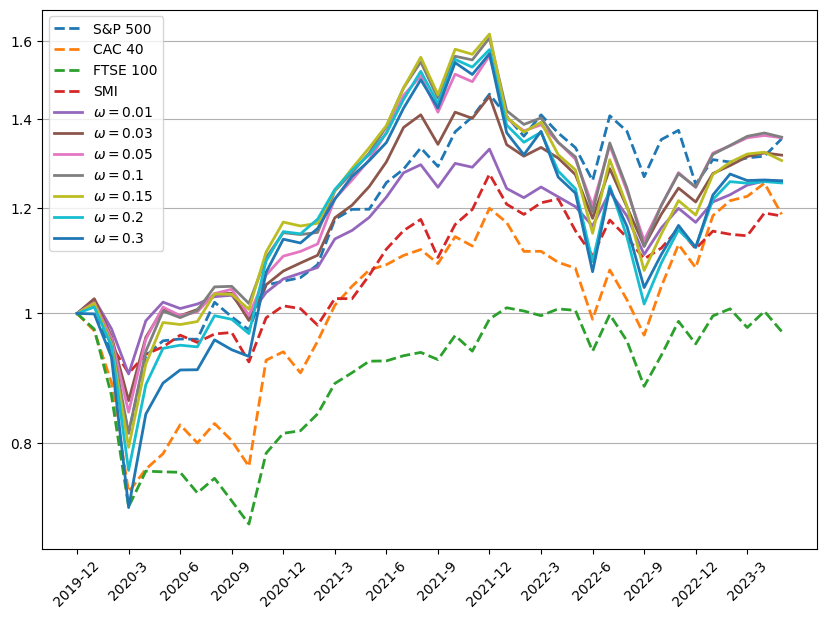

,0,6,12,18,24,30,36,41
S&P 500,1.0,0.956884,1.057322,1.25343,1.460259,1.257872,1.250225,1.351874
CAC 40,1.0,0.82511,0.936009,1.087862,1.199092,0.990077,1.082167,1.186633
FTSE 100,1.0,0.76022,0.813109,0.921401,0.990416,0.937099,0.948814,0.969474
SMI,1.0,0.963269,1.013301,1.117494,1.27198,1.105142,1.118277,1.18326
$\omega=0.01$,0.999998,1.008566,1.061409,1.222362,1.328084,1.163077,1.170335,1.256825
$\omega=0.03$,0.999999,0.996137,1.075963,1.299123,1.455193,1.178428,1.212235,1.314328
$\omega=0.05$,1.0,0.996142,1.104029,1.366813,1.5609,1.204677,1.243037,1.354337
$\omega=0.1$,0.999999,0.992795,1.149621,1.380864,1.609185,1.191318,1.244118,1.355757
$\omega=0.15$,1.000002,0.981085,1.170909,1.383033,1.619911,1.148462,1.185265,1.302199
$\omega=0.2$,1.0,0.946716,1.151729,1.36478,1.576913,1.093545,1.120893,1.252749


In [22]:
filename = f"{folderpath}/x_plot2.csv"
legend_entries = ["S&P 500", "CAC 40", "FTSE 100", "SMI",
                  r"$\omega=0.01$",r"$\omega=0.03$",r"$\omega=0.05$",r"$\omega=0.1$",r"$\omega=0.15$",r"$\omega=0.2$",r"$\omega=0.3$"]
linestyles = ["--"]*4 + ["-"]*7
plot_performance(filename, actual_returns, plotting_interval, legend_entries, linestyles, "out_of_sample(30)")

# Correlation matrix grouping

In [15]:
summary.sort_values("Industry")[["Industry","index"]]

,Industry,index
COA.L,Apparel,454
CRI.PA,Apparel,121
YPSN.SW,"Biotech, health care & pharma",434
ABT,"Biotech, health care & pharma",538
ACAD,"Biotech, health care & pharma",539
...,...,...
^FCHI,NaN,725
^GDAXI,NaN,726
^FTSE,NaN,727
^SSMI,NaN,728


In [10]:
industry_indicators

,"Industry_Food, beverage & agriculture",Industry_Manufacturing,Industry_Infrastructure,Industry_Services,Industry_Materials,Industry_Fossil Fuels,Industry_Retail,Industry_Transportation services,"Industry_Biotech, health care & pharma",Industry_Power generation,Industry_Hospitality,Industry_Apparel
AGR.VI,1,0,0,0,0,0,0,0,0,0,0,0
ANDR.VI,0,1,0,0,0,0,0,0,0,0,0,0
CAI.VI,0,0,1,0,0,0,0,0,0,0,0,0
EBS.VI,0,0,0,1,0,0,0,0,0,0,0,0
EVN.VI,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
^FCHI,0,0,0,0,0,0,0,0,0,0,0,0
^GDAXI,0,0,0,0,0,0,0,0,0,0,0,0
^FTSE,0,0,0,0,0,0,0,0,0,0,0,0
^SSMI,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
summary2 = pd.concat([summary, industry_indicators])
summary2

,Country,Company Name,CDP Score,Industry,CE (tCO2e),Estimated EVIC (MEUR),Emission intensity (tCO2e/MEUR),KS p-value,DoF,Location,...,Industry_Infrastructure,Industry_Services,Industry_Materials,Industry_Fossil Fuels,Industry_Retail,Industry_Transportation services,"Industry_Biotech, health care & pharma",Industry_Power generation,Industry_Hospitality,Industry_Apparel
AGR.VI,Austria,AGRANA Beteiligungs-AG,3.0,"Food, beverage & agriculture",381000.0,2035.221761,187.203187,0.995929,6.128094,0.002111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANDR.VI,Austria,ANDRITZ AG,4.5,Manufacturing,222452.0,3354.578799,66.312945,0.979662,4.706482,0.017056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAI.VI,Austria,CA Immobilien Anlagen AG,7.0,Infrastructure,50945.0,4327.273630,11.773002,0.938119,1.924503,0.008265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EBS.VI,Austria,Erste Group Bank AG,5.5,Services,71950.0,63710.792646,1.129322,0.913163,2.632979,0.014417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVN.VI,Austria,EVN AG,5.0,Infrastructure,3050754.0,6717.123518,454.175659,0.993103,3.830549,0.005547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
^FCHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
^GDAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
^FTSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
^SSMI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
